In [196]:
import pandas as pd
import random 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [216]:
newsDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/newsData/fullDataWithNER.tsv", sep="\t")

/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (2,3,10,11,12,13,14,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [219]:
newsDf["date"] = pd.to_datetime(newsDf["date"])

In [220]:
print("we start with a dataframe of dimension: " + str(newsDf.shape)) 

we start with a dataframe of dimension: (5081145, 45)


### What are the duplicates?? 
looking at duplicates on [content, source] now

In [203]:
#get all of the duplicates except for the first one 
dupes = newsDf.duplicated(subset=["content", "source"], keep="first")
contentDupes = list(newsDf.loc[dupes, "content"])

In [207]:
#necessary but takes up a lot of notebook space
#random.sample(contentDupes, 10)

In [208]:
groupedDupes = newsDf.loc[dupes, ["content", "source", "title", "date", "national"]].groupby(by=["content", "source"]).agg(list)

In [209]:
groupedDupes["count"] = groupedDupes["national"].apply(len)

In [210]:
groupedDupes.sort_values(["count"], ascending=False)[:10]

,,title,date,national,count
content,source,,,,
Click to share on Facebook ( Opens in new window ),conspiracydailyupdate,[@Qanon76: @SeanCordicon Thank you. God Bless ...,"[2020-03-15 00:00:00, 2020-03-15 00:00:00, 202...","[True, True, True, True, True, True, True, Tru...",16460
"Post was not sent - check your email addresses !\nEmail check failed , please try again Sorry , your @ @ @ @ @ by email .",citizenfreepress,"[This is not winning…, Recall petition for Gre...","[2020-04-14 00:00:00, 2020-04-14 00:00:00, 202...","[True, True, True, True, True, True, True, Tru...",12934
"Enter your user name and password in the fields above to gain access to the subscriber content on this site.\n\nYour subscription includes one set of login credentials for your exclusive use. Security features have been integrated on this site: If someone signs in with your credentials while you are logged in, the site will automatically close your ongoing login and you will lose access at that time.\n\nTo inquire about group subscriptions for your organization please email Shaun Witt for special pricing.\n\nIf you feel your login credentials are being used by a second party, contact customer service at 877-615-9536 for assistance in changing your password.\n\nAlready a paid subscriber but not registered for online access yet? For instructions on how to get premium web access, click here.",thejournalrecord,[RI regulators OK plan to buy power from Conn....,"[2020-04-03 00:00:00, 2020-04-03 00:00:00, 202...","[False, False, False, False, False, False, Fal...",8094
"HuffPost is part of Verizon Media .\nWe and our partners will store and/or access information on your device through @ @ @ @ @ similar technologies , to display personalised ads and content , for ad and content measurement @ @ @ @ @ development .\nYour personal data that may be used • Information about your device and @ @ @ @ @ IP address • Browsing and search activity while using Verizon Media websites and apps Find @ @ @ @ @ use your information in our Privacy Policy and Cookie Policy .\nTo enable Verizon Media @ @ @ @ @ your personal data select ' I agree ' , or select 'Manage settings ' for @ @ @ @ @ your choices .\nYou can change your choices at any time by visiting Your Privacy @ @",thehuffingtonpostuk,[The Tories Are Protecting An Alleged Rapist –...,"[2020-08-14 00:00:00, 2020-08-14 00:00:00, 202...","[True, True, True, True, True, True, True, Tru...",6281
"As an Amazon Associate , I earn from qualifying purchases .",instapundit,"[AT AMAZON, WaterBOB Bathtub Emergency Water S...","[2020-01-07 00:00:00, 2020-01-07 00:00:00, 202...","[True, True, True, True, True, True, True, Tru...",5901
HuffPost is part of Verizon Media .\nClick ' I agree ' to allow Verizon Media and our partners to @ @ @ @ @ to access your device and use your data ( including location ) to understand your @ @ @ @ @ measure personalised ads .\nWe will also provide you with personalised ads on partner products @ @ @ @ @ we use your data in our Privacy Centre .\nOnce you confirm your privacy choices @ @ @ @ @ changes at any time by visiting your Privacy dashboard .\nClick 'Learn more ' to @ @ @ @ @ Media and our partners collect and use data .,thehuffingtonpostuk,[Wendy Williams Tearfully Apologises After Bac...,"[2020-02-14 00:00:00, 2020-02-14 00:00:00, 202...","[True, True, True, True, True, True, True, Tru...",5766
By subscribing I accept the terms of use,jerusalempost,[U.S. deploying 750 soldiers after protest at ...,"[2020-01-01 00:00:00, 2020-01-07 00:00:00, 202...","[True, True, True, True, True, True, True, Tru...",5610
"Sign up for alerts from The Irish Times Just click on “ Allow Notifications ” on the message appearing on @ @ @ @ @ .\nWe will send you a quick reminder in the future , in case you @ @ @ @",theirishtimes,"[Teenager killed dog with two kicks, court tol...","[2021-06-24 00:00:00, 2021-06-24 00:00:00, 202...","[True, True, True, True, True, True, True, Tru...",5334
PayPal : Donate in USD PayPal : Don

In [211]:
#is it just a handful of articles? 
outletDupes = groupedDupes.reset_index()[["source", "count"]].groupby(by = "source").agg(sum)
outletDupes = outletDupes.sort_values("count", ascending=False).reset_index().rename(columns={"count":"dup_count"})

In [212]:
outletDupes.head(4)

,source,dup_count
0,newsbusters,39096
1,thetelegraph,24791
2,cnn,22840
3,drudgereport,21429


In [213]:
outletCounts = pd.DataFrame(newsDf["source"].value_counts())
outletCounts = outletCounts.reset_index().rename(columns={"index":"source", "source":"total_counts"})
dupPercentage = pd.merge(outletDupes, outletCounts, on="source", how="left")
dupPercentage["duplicate_percentage"] = (dupPercentage["dup_count"] / dupPercentage["total_counts"]) * 100

In [214]:
dupPercentage = dupPercentage.sort_values("duplicate_percentage", ascending=False).reset_index()

## Plot percentage of outlets removed 

In [225]:
"""
fig, ax = plt.subplots(figsize=[9,20])
#ax[0].barh(dupPercentage.loc[40:60, "source"], dupPercentage.loc[40:60, "duplicate_percentage"])
pps = plt.barh(dupPercentage.loc[:70, "source"], dupPercentage.loc[:70, "duplicate_percentage"], color="green")


for p in pps:
   width = p.get_width()
   ax.annotate(round(width, 2),
      xy=(width, p.get_y() + p.get_height()),
      xytext=(20, -12), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
plt.tight_layout()
#"""

'\nfig, ax = plt.subplots(figsize=[9,20])\n#ax[0].barh(dupPercentage.loc[40:60, "source"], dupPercentage.loc[40:60, "duplicate_percentage"])\npps = plt.barh(dupPercentage.loc[:70, "source"], dupPercentage.loc[:70, "duplicate_percentage"], color="green")\n\n\nfor p in pps:\n   width = p.get_width()\n   ax.annotate(round(width, 2),\n      xy=(width, p.get_y() + p.get_height()),\n      xytext=(20, -12), # 3 points vertical offset\n      textcoords="offset points",\n      ha=\'center\', va=\'bottom\')\nplt.tight_layout()\n#'

In [226]:
"""
fig, ax = plt.subplots(figsize=[8,20])
#ax[0].barh(dupPercentage.loc[40:60, "source"], dupPercentage.loc[40:60, "duplicate_percentage"])
pps = plt.barh(dupPercentage.loc[70:140, "source"], dupPercentage.loc[70:140, "duplicate_percentage"], color="green")
ax.set_xlim([0, 100])

for p in pps:
   width = p.get_width()
   ax.annotate(round(width, 2),
      xy=(width, p.get_y() + p.get_height()),
      xytext=(20, -15), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
plt.tight_layout()
#"""

'\nfig, ax = plt.subplots(figsize=[8,20])\n#ax[0].barh(dupPercentage.loc[40:60, "source"], dupPercentage.loc[40:60, "duplicate_percentage"])\npps = plt.barh(dupPercentage.loc[70:140, "source"], dupPercentage.loc[70:140, "duplicate_percentage"], color="green")\nax.set_xlim([0, 100])\n\nfor p in pps:\n   width = p.get_width()\n   ax.annotate(round(width, 2),\n      xy=(width, p.get_y() + p.get_height()),\n      xytext=(20, -15), # 3 points vertical offset\n      textcoords="offset points",\n      ha=\'center\', va=\'bottom\')\nplt.tight_layout()\n#'

In [227]:
"""
fig, ax = plt.subplots(figsize=[8,20])
#ax[0].barh(dupPercentage.loc[40:60, "source"], dupPercentage.loc[40:60, "duplicate_percentage"])
pps = plt.barh(dupPercentage.loc[140:170, "source"], dupPercentage.loc[140:170, "duplicate_percentage"], color="green")
ax.set_xlim([0, 100])

for p in pps:
   width = p.get_width()
   ax.annotate(round(width, 2),
      xy=(width, p.get_y() + p.get_height()),
      xytext=(20, -16), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
plt.tight_layout()
#"""

'\nfig, ax = plt.subplots(figsize=[8,20])\n#ax[0].barh(dupPercentage.loc[40:60, "source"], dupPercentage.loc[40:60, "duplicate_percentage"])\npps = plt.barh(dupPercentage.loc[140:170, "source"], dupPercentage.loc[140:170, "duplicate_percentage"], color="green")\nax.set_xlim([0, 100])\n\nfor p in pps:\n   width = p.get_width()\n   ax.annotate(round(width, 2),\n      xy=(width, p.get_y() + p.get_height()),\n      xytext=(20, -16), # 3 points vertical offset\n      textcoords="offset points",\n      ha=\'center\', va=\'bottom\')\nplt.tight_layout()\n#'

## Number of articles removed 

In [228]:
dupPercentage.sort_values("dup_count", ascending=False)[:40]

,index,source,dup_count,total_counts,duplicate_percentage
8,0,newsbusters,39096,53632,72.896778
68,1,thetelegraph,24791,62276,39.808273
78,2,cnn,22840,69071,33.067423
82,3,drudgereport,21429,66979,31.993610
16,4,press,19702,30217,65.201708
1,5,conspiracydailyupdate,16464,16789,98.064209
17,6,citizenfreepress,13610,21858,62.265532
13,7,thehuffingtonpostuk,13505,19144,70.544296
130,8,cbsnews,10937,73250,14.931058
4,9,fortune,8849,10023,88.286940


## Duplicate Cluster Size Percentiles  

In [229]:
np.percentile(groupedDupes["count"], [0, 10, 50, 90, 95, 99])

array([ 1.,  1.,  1.,  4.,  5., 17.])

## Outlet Duplicate Number Distribution

Text(0, 0.5, '# of outlets')

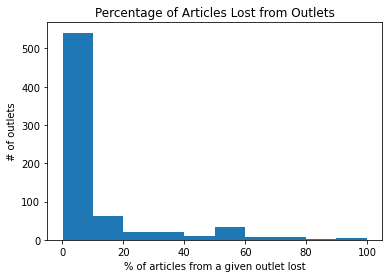

In [230]:
plt.hist(dupPercentage["duplicate_percentage"])
plt.title("Percentage of Articles Lost from Outlets")
plt.xlabel("% of articles from a given outlet lost")
plt.ylabel("# of outlets")

In [231]:
#first cleaning step is just taking out articles that might be duplicates from the same outlet 
#we want to sort on date 
newsDf = newsDf.sort_values("date")

newsDf = newsDf.drop_duplicates(subset=["content", "source"])

In [232]:
print("len after removing duplicates on [content, source]: " + str(newsDf.shape))

len after removing duplicates on [content, source]: (4567468, 45)


In [233]:
print("difference is: " + str(5081145 - 4567468))
print(str((513677 / 5081145) * 100 ) + "%")

difference is: 513677
10.109473356891016%


### What are the duplicates?? 
looking at duplicates on [url, content] now

In [234]:
dupes = newsDf.duplicated(subset=["url", "content"], keep=False)

In [235]:
groupedDupes = newsDf.loc[dupes, ["content", "url", "source", "title", "date", "national"]].groupby(by=["url", "content"]).agg(list)

In [236]:
groupedDupes["count"] = groupedDupes["title"].apply(len)

- It seems like the dates are typically the same for the duplicates, but there are exceptions such as row 68211
- We have 68,211 examples of this syndication/pack journalism etc... happening 

In [237]:
groupedDupes.sort_values("count", ascending=False).reset_index()

,url,content,source,title,date,national,count
0,https://www.news.com.au/finance/business/media...,Global media site BuzzFeed will end its Austra...,"[echonews, tweeddailynews, cqnews, gladstoneob...","[BuzzFeed Australia to close, BuzzFeed Austral...","[2020-06-27 00:00:00, 2020-06-27 00:00:00, 202...","[True, True, True, True, True, True, True, Tru...",22
1,https://www.news.com.au/finance/business/media...,"The website , which was founded in 2006 , beca...","[cairnspost, ntnews, geelongadvertiser, herald...","[BuzzFeed Australia to close, BuzzFeed Austral...","[2020-05-14 00:00:00, 2020-05-14 00:00:00, 202...","[True, True, True, True, True]",5
2,https://www.rivertowns.net/lifestyle/home-and-...,Many of you have noticed that the public garde...,"[southwashingtoncountybulletin, republicaneagl...",[Column: Victory Gardens return during the pan...,"[2020-06-28 00:00:00, 2020-06-28 00:00:00, 202...","[False, False, False, False]",4
3,https://www.rivertowns.net/newsmd/coronavirus/...,"ROCHESTER, Minn. — Minnesota set a new high ma...","[republicaneagle, countybulletin, stargazette,...",[Minnesota sets new single-day mark for COVID-...,"[2020-09-20 00:00:00, 2020-09-20 00:00:00, 202...","[False, False, False, False]",4
4,https://www.rivertowns.net/newsmd/coronavirus/...,"ROCHESTER, Minn. — It was just another announc...","[republicaneagle, stargazette, countybulletin,...",[Minnesota health officials stopped reporting ...,"[2020-09-24 00:00:00, 2020-09-24 00:00:00, 202...","[False, False, False, False]",4
...,...,...,...,...,...,...,...
68207,https://triblive.com/news/world/california-ado...,TribLIVE's Daily and Weekly email newsletters ...,"[pittsburghtribunereview, murrysvillestar]","[California adopts tough standards for trucks,...","[2021-12-10 00:00:00, 2021-12-10 00:00:00]","[False, False]",2
68208,https://triblive.com/news/world/california-bec...,LOS ANGELES — California has become the first ...,"[murrysvillestar, pittsburghtribunereview]","[California becomes first state to pass 600,00...","[2020-08-15 00:00:00, 2020-08-15 00:00:00]","[False, False]",2
68209,https://triblive.com/news/world/california-bil...,"SACRAMENTO, Calif. — A California lawmaker is ...","[pittsburghtribunereview, murrysvillestar]",[California bill would ban intersex surgery fo...,"[2021-01-16 00:00:00, 2021-01-16 00:00:00]","[False, False]",2
68210,https://triblive.com/news/world/california-fac...,"VACAVILLE, Calif. — California’s firefighting ...","[pittsburghtribunereview, murrysvillestar]",[California faces huge fires before usual peak...,"[2020-08-26 00:00:00, 2020-08-26 00:00:00]","[False, False]",2


In [238]:
#is it just a handful of articles? 
#outletDupes = groupedDupes.reset_index()[["source", "count"]].groupby(by = "source").agg(sum)
#outletDupes = outletDupes.sort_values("count", ascending=False).reset_index().rename(columns={"count":"dup_count"})
outletDupes = newsDf.loc[dupes, ["title", "source"]].groupby(by="source").agg(len).rename(columns={"title":"dup_articles"}).reset_index()
outletDupes.sort_values("dup_articles", ascending=False)

,source,dup_articles
107,murrysvillestar,31254
130,pittsburghtribunereview,31254
232,whatreallyhappened,5784
158,stargazette,4393
142,republicaneagle,4391
...,...,...
159,stillnessinthestorm,1
203,thevaccinereaction,1
13,americanintelligencemedia,1
98,junksciencecom,1


In [239]:
outletTotals = pd.DataFrame(newsDf["source"].value_counts()).reset_index().rename(columns={"index":"source", "source":"total_articles"})
mergedOutletCounts = pd.merge(outletDupes, outletTotals, on="source", how="left")
mergedOutletCounts["dup_percentage"] = (mergedOutletCounts["dup_articles"] / mergedOutletCounts["total_articles"]) * 100
mergedOutletCounts.sort_values("dup_articles", ascending=False)[:40]

,source,dup_articles,total_articles,dup_percentage
107,murrysvillestar,31254,31442,99.402074
130,pittsburghtribunereview,31254,31507,99.197004
232,whatreallyhappened,5784,80153,7.216199
158,stargazette,4393,4407,99.682324
142,republicaneagle,4391,4454,98.585541
47,countybulletin,4366,4395,99.340159
156,southwashingtoncountybulletin,4362,4432,98.420578
54,dailyguide,3948,3948,100.000000
145,rolladailynews,3948,3948,100.000000
21,bbcuk,3842,29181,13.166101


Text(0, 0.5, '# of outlets')

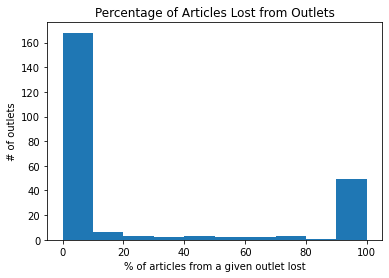

In [240]:
plt.hist(mergedOutletCounts["dup_percentage"])
plt.title("Percentage of Articles Lost from Outlets")
plt.xlabel("% of articles from a given outlet lost")
plt.ylabel("# of outlets")

Text(0, 0.5, '# of outlets')

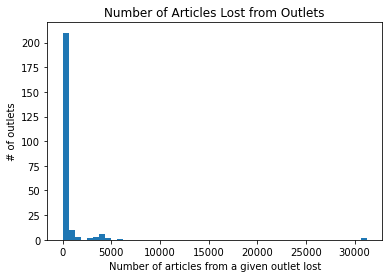

In [241]:
plt.hist(mergedOutletCounts["dup_articles"], bins=50)
plt.title("Number of Articles Lost from Outlets")
plt.xlabel("Number of articles from a given outlet lost")
plt.ylabel("# of outlets")

In [242]:
newsDf = newsDf.drop_duplicates(subset=["url", "content"])

In [244]:
print("len after removing duplicates on [url, content]: " + str(newsDf.shape)) 

len after removing duplicates on [url, content]: (4567468, 45)


In [245]:
print("difference is: " + str(4567468 - 4490511))

difference is: 76957


In [247]:
76957 / 4567468 * 100

1.6848941251476748

In [ ]:
newsDf.columns

How did removals change our distribution of outlets? 
Without filtering out url duplicates..

In [248]:
newsDf.to_csv("/shared/3/projects/newsDiffusion/data/processed/newsData/fullDataWithNERCleaned.tsv", sep="\t")

total sources: 835


<BarContainer object of 25 artists>

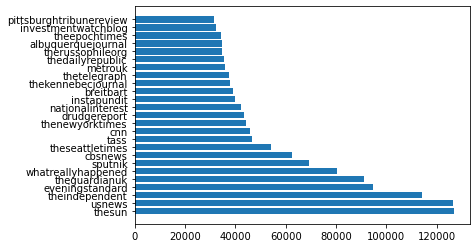

In [121]:
SOURCE_NUM = 25
sources = list(newsDf["source"].value_counts().index)
print("total sources: " + str(len(sources)))
sources = sources[:25]
articleCounts = list(newsDf["source"].value_counts())[:25]

plt.barh(sources, articleCounts)